# Let's perform inference!
<!--- @wandbcode{ethz-hackathon} -->


In [1]:
from pathlib import Path
from types import SimpleNamespace
import torch, wandb
from miniminiai import show_images
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

You need to load the original model weights first:

In [2]:
config = SimpleNamespace(
    #model_base="runwayml/stable-diffusion-v1-5",
    model_base="hakurei/waifu-diffusion",
    device="cuda",
)

WANDB_TEAM="ethweebs"
WANDB_PROJECT_NAME="ethz-hackathon"

#LORA_WEIGHTS_AT="capecape/ethz-hackathon/6a6wsrsl_lora:v0"
#LORA_WEIGHTS_AT="ethweebs/ethz-hackathon/e5ghswz7_lora:v0" # standard sd model fine tuned on lambdalabs/pokemon-blip-captions
#LORA_WEIGHTS_AT="ethweebs/ethz-hackathon/mzxank1u_lora:v0" # waifu diffusion model fine tuned on lambdalabs/pokemon-blip-captions
#LORA_WEIGHTS_AT="ethweebs/ethz-hackathon/2sbqktyq_lora:v0" # waifu diffusion model fine tuned on scraped saitama images
LORA_WEIGHTS_AT="ethweebs/ethz-hackathon/ao6w5t64_lora:v0" # waifu diffusion model fine tuned on scraped saitama images & eth building images
#LORA_WEIGHTS_AT="" # waifu diffusion model fine tuned on scraped saitama images & eth building images & einstein images

Create the diffusion Pipeline

In [3]:
pipe = DiffusionPipeline.from_pretrained(config.model_base, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Let's create a W&B run

In [4]:
run = wandb.init(entity=WANDB_TEAM, project=WANDB_PROJECT_NAME, job_type="inference", group="lora_saitama_inference", config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: joebaumann (ethweebs). Use `wandb login --relogin` to force relogin


Let's create a Table to keep track of all our generations

In [5]:
table = wandb.Table(columns=["image", "num_inference_steps", "guidance_scale", "cross_attn_scale"])

Load the LoRA attention weights on top of the pretrained Stable Diffusion model

In [6]:
at = run.use_artifact(LORA_WEIGHTS_AT, type="model")
lora_model_path = list(Path(at.download()).glob("*.bin"))[0]

wandb:   1 of 1 files downloaded.  


In [7]:
# older diffusers style loading
pipe.unet.load_attn_procs(lora_model_path)

# new diffusers and Dreambooth style loading
# pipe.load_attn_procs(lora_model_path)
pipe.to(config.device);

Generating with 50% conditioning (interpolating base weights and LoRA weigths)

In [8]:
def generate_images(prompts, num_inference_steps=25, guidance_scale=7.5, cross_attn_scale=0.5):
    images = pipe(
        prompts,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        cross_attention_kwargs={"scale": cross_attn_scale},
    ).images
    for img in images:
        table.add_data(wandb.Image(img),  num_inference_steps, guidance_scale, cross_attn_scale)
    return images

  0%|          | 0/25 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


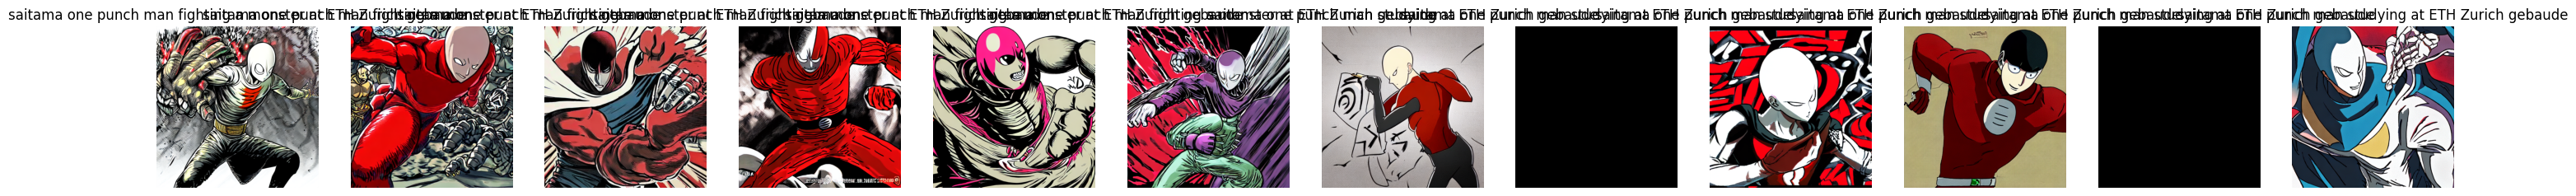

In [10]:
prompts = ["saitama one punch man fighting a monster at ETH Zurich gebaude", 
           "saitama one punch man fighting a monster at ETH Zurich gebaude", 
           "saitama one punch man fighting a monster at ETH Zurich gebaude", 
           "saitama one punch man fighting a monster at ETH Zurich gebaude", 
           "saitama one punch man fighting a monster at ETH Zurich gebaude", 
           "saitama one punch man fighting a monster at ETH Zurich gebaude", 
           "saitama one punch man studying at ETH Zurich gebaude",
           "saitama one punch man studying at ETH Zurich gebaude",
           "saitama one punch man studying at ETH Zurich gebaude",
           "saitama one punch man studying at ETH Zurich gebaude",
           "saitama one punch man studying at ETH Zurich gebaude",
           "saitama one punch man studying at ETH Zurich gebaude"]
images = generate_images(prompts, cross_attn_scale=0.95)
show_images(images, titles=prompts, nrows=1)

  0%|          | 0/25 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


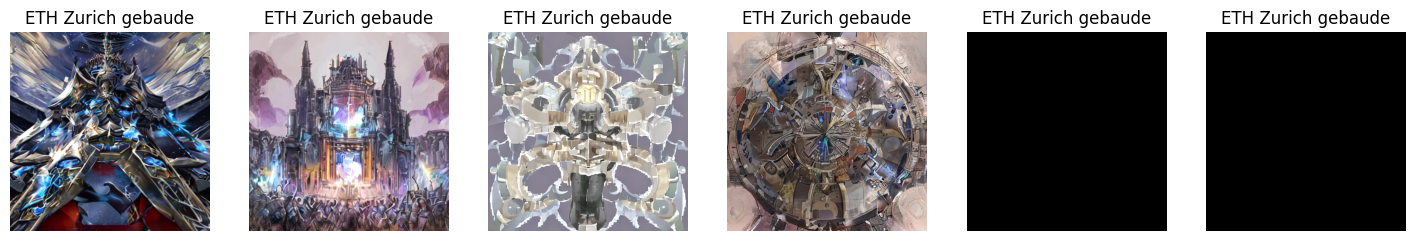

In [13]:
prompts = ["ETH Zurich gebaude", 
           "ETH Zurich gebaude", 
           "ETH Zurich gebaude", 
           "ETH Zurich gebaude", 
           "ETH Zurich gebaude", 
           "ETH Zurich gebaude"]
images = generate_images(prompts, cross_attn_scale=1)
show_images(images, titles=prompts, nrows=1)